다음과 같은 단계로 이루어져 있습니다:

> 1. 필요한 라이브러리와 사용자 정의 모듈을 불러옵니다.

> 2. 데이터 파일 경로를 설정합니다.

> 3. 결과를 저장하기 위한 함수를 정의합니다.

> 4. 훈련 데이터와 테스트 데이터를 불러옵니다.

> 5. 훈련 데이터를 사용하여 Configuration을 계산하고 저장합니다.

> 6. 시험용 데이터를 사용하여 Univariate Monitoring을 실행합니다.

In [1]:
# 필요한 라이브러리들을 불러옵니다.
import os, sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
# 상위 디렉토리로 경로를 설정합니다.
sys.path.append(os.path.abspath('../'))

# 사용자 정의 모듈을 불러옵니다.
from classify_fault.set_config import *
from classify_fault.fault_detection import *

In [2]:
data_path = '../data/TemperatureTrain.csv'
data_path2 = '../data/Temperature.csv'
config_save_path = '../config/example_configAll_multiFaults.json'

In [3]:
# 훈련 데이터와 테스트 데이터를 불러옵니다.
train_data = pd.read_csv(data_path, index_col=[0])
test_data = pd.read_csv(data_path2, index_col=[0])

tag_list = train_data.columns.to_list()
test_tag_list = test_data.columns.to_list()
test_tag_list.remove('temp5Normal')
tag_list, test_tag_list

(['temp5'],
 ['temp5Bias', 'temp5Frozen', 'temp5Drift', 'temp5Gain', 'temp5All'])

In [4]:
train_data[tag_list].head()

,temp5
DateTime,
2022-08-01 00:00:00,1220.54
2022-08-01 00:10:00,1210.31
2022-08-01 00:20:00,1206.14
2022-08-01 00:30:00,1200.39
2022-08-01 00:40:00,1204.22


In [5]:
test_data[test_tag_list].head()

,temp5Bias,temp5Frozen,temp5Drift,temp5Gain,temp5All
DateTime,,,,,
2023-01-01 0:00,1192.58,1192.58,1192.58,1192.58,1192.58
2023-01-01 0:01,1193.04,1193.04,1193.04,1193.04,1193.04
2023-01-01 0:02,1193.46,1193.46,1193.46,1193.46,1193.46
2023-01-01 0:03,1192.96,1192.96,1192.96,1192.96,1192.96
2023-01-01 0:04,1190.98,1190.98,1190.98,1190.98,1190.98


In [6]:
def set_config():
        # 훈련 데이터를 사용하여 Configuration을 계산합니다.
    tmp = pd.concat([train_data[tag_list], train_data[tag_list], 
                    train_data[tag_list], train_data[tag_list], 
                    train_data[tag_list]], axis=1)

    # 여러 변수에 대한 테스트를 진행하기 위하여 Configuration을 중복해서 작성하였습니다.
    config = calculate_variables_config(tag_list=test_tag_list, data=tmp.values)

    # Moving Boundary를 적용합니다.
    for tag in test_tag_list:
        config[tag]['statistic']['boundary_type'] = 'moving'

    # Configuration을 저장합니다.
    save_config(data=config, json_file_path=config_save_path)

    tracking_size = 5    # 임의 설정
tracking_size = 5    # 임의 설정

In [7]:
def get_matching_keys(res):
    """
    주어진 결과 딕셔너리에서 success와 fault_detected가 True인 경우에만,
    각각 Frozen, Boundary, Dynamics, Drift 키의 값을 확인하여
    True인 경우에 해당하는 키를 반환하는 함수입니다.

    Args:
        res (dict): 결과를 포함하는 딕셔너리. 다음 키를 포함해야 합니다:
                   'success', 'fault_detected', 'Frozen', 'Boundary', 'Dynamics', 'Drift', 'values'.

    Returns:
        list or None: 조건에 맞는 경우, 각 키에 해당하는 키 값을 포함하는 리스트를 반환하고,
                      그렇지 않으면 None을 반환합니다.

    Examples:
        res = {'success': True,
               'fault_detected': True,
               'Frozen': True,
               'Boundary': False,
               'Dynamics': False,
               'Drift': False,
               'values': {'frozen': 0.84, 'boundary': [False, 1190.98], 'dynamics': 0.84, 'drift': [0, 0]}}

        result = get_matching_keys(res)
        print(result)  # ['Frozen']
    """
    if res['success'] and res['fault_detected']:
        result = []
        keys = ['Frozen', 'Boundary', 'Dynamics', 'Drift']
        for key in keys:
            if res[key]:
                result.append(key.lower())
        return result
    return None

In [8]:
"""
여러 개의 변수에 대해서 고장 감지를 수행할 경우 아래와 같이 results가 반환됩니다.
    {'temp5Bias': {'success': True, 'fault_detected': False, 
                   'Frozen': False, 'Boundary': False, 'Dynamics': False, 'Drift': False, 
                   'values': {'frozen': 0.8425000000000296, 
                              'boundary': [False, 1190.51], 
                              'dynamics': 0.8425000000000296, 
                              'drift': [0, 0]}, 
                   'statistics_update': None, 'boundary_limits_update': None, 'drift_params_update': {'cusum_plus': 0, 'cusum_minus': 0, 'ewma_smoothed': 1191.7346180275815}, 
                   'message': '-'}, 
    'temp5Frozen': {'success': True, 'fault_detected': False, 
                   'Frozen': False, 'Boundary': False, 'Dynamics': False, 'Drift': False, 
                   'values': {'frozen': 0.8425000000000296, 
                              'boundary': [False, 1190.51], 
                              'dynamics': 0.8425000000000296, 
                              'drift': [0, 0]}, 
                   'statistics_update': None, 'boundary_limits_update': None, 'drift_params_update': {'cusum_plus': 0, 'cusum_minus': 0, 'ewma_smoothed': 1191.7346180275815}, 
                   'message': '-'}, 
    ...
    }
"""

"\n여러 개의 변수에 대해서 고장 감지를 수행할 경우 아래와 같이 results가 반환됩니다.\n    {'temp5Bias': {'success': True, 'fault_detected': False, \n                   'Frozen': False, 'Boundary': False, 'Dynamics': False, 'Drift': False, \n                   'values': {'frozen': 0.8425000000000296, \n                              'boundary': [False, 1190.51], \n                              'dynamics': 0.8425000000000296, \n                              'drift': [0, 0]}, \n                   'statistics_update': None, 'boundary_limits_update': None, 'drift_params_update': {'cusum_plus': 0, 'cusum_minus': 0, 'ewma_smoothed': 1191.7346180275815}, \n                   'message': '-'}, \n    'temp5Frozen': {'success': True, 'fault_detected': False, \n                   'Frozen': False, 'Boundary': False, 'Dynamics': False, 'Drift': False, \n                   'values': {'frozen': 0.8425000000000296, \n                              'boundary': [False, 1190.51], \n                              'dynamics': 0.8425000000000

In [9]:
import re

def compare_execution_time(log_text):
    function_times = {}
    pattern = r'(\w+) elapsed: (\d+\.\d+)sec \(real\) / (\d+\.\d+)sec \(cpu\)'

    matches = re.findall(pattern, log_text)
    for match in matches:
        function_name = match[0]
        real_time = float(match[1])
        cpu_time = float(match[2])
        function_times[function_name] = (real_time, cpu_time)

    return function_times

In [10]:
import time
import cProfile
import re

def my_function():
    start = time.time()
    # 트래킹 사이즈부터 테스트 데이터의 끝까지 반복
    keys = ['frozen', 'boundary', 'dynamics', 'drift']

    tags = {tag: [] for tag in test_tag_list}
    detecteds, frz_res, bounds_res, dyn_res, drft_res, high_boundary, low_boundary = [deepcopy(tags) for _ in range(7)]

    for i in tqdm(range(tracking_size, 1000)):     # len(test_data)
        test_ = test_data[test_tag_list].values[i - tracking_size +1 : i + 1, :]
        res = detect_faults(data=test_, tag_list=test_tag_list, config_path=config_save_path)
        last_value = test_data[test_tag_list].values[i]
        config = load_config(json_file_path=config_save_path)
        for tag in test_tag_list:
            result = get_matching_keys(res[tag]) or []

            frz_res[tag].append('frozen' in result)
            bounds_res[tag].append('boundary' in result)
            dyn_res[tag].append('dynamics' in result)
            drft_res[tag].append('drift' in result)

            detecteds[tag].append(bool(result))
            

            high_boundary[tag].append(config[tag]['boundary_limits']['high'])
            low_boundary[tag].append(config[tag]['boundary_limits']['low'])
    end = time.time()

    print(f"실행시간은 {(end- start)}sec 입니다.")
    
    return detecteds, frz_res, bounds_res, dyn_res, drft_res, high_boundary, low_boundary

for i in range(3):
    set_config()
    detecteds, frz_res, bounds_res, dyn_res, drft_res, high_boundary, low_boundary = my_function()

  0%|          | 0/995 [00:00<?, ?it/s]

100%|██████████| 995/995 [00:06<00:00, 156.18it/s]


실행시간은 6.386895656585693sec 입니다.


100%|██████████| 995/995 [00:05<00:00, 168.46it/s]


실행시간은 5.9086244106292725sec 입니다.


100%|██████████| 995/995 [00:06<00:00, 156.60it/s]

실행시간은 6.354853630065918sec 입니다.


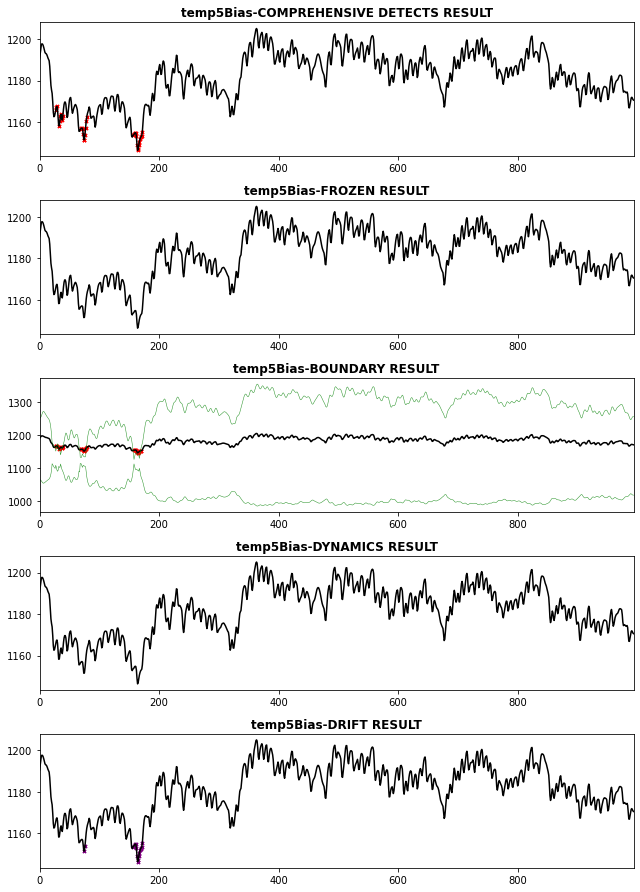

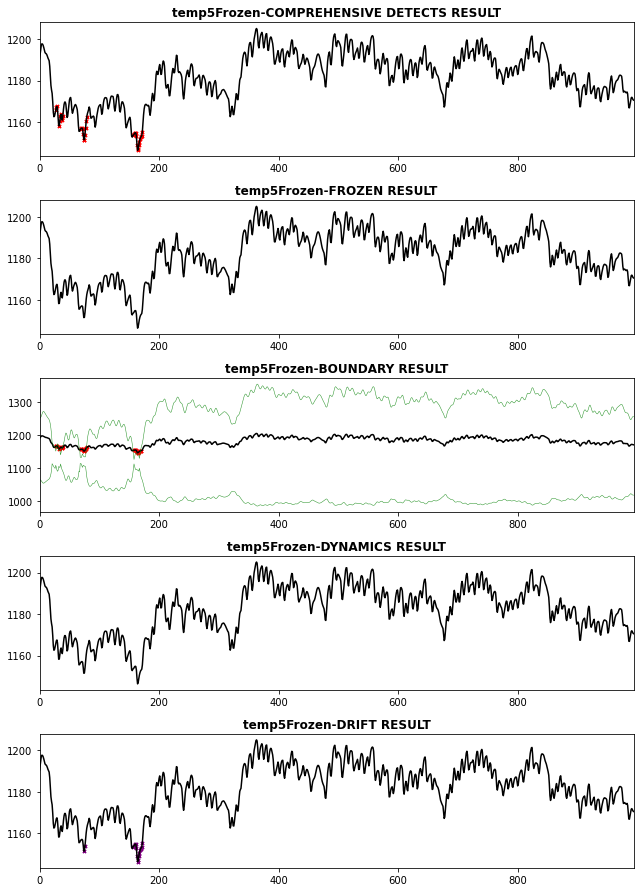

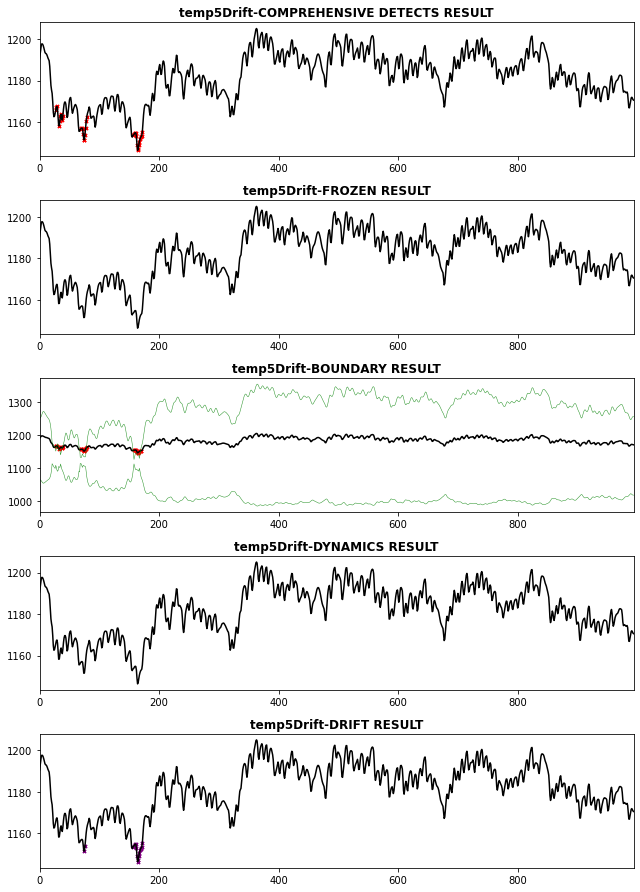

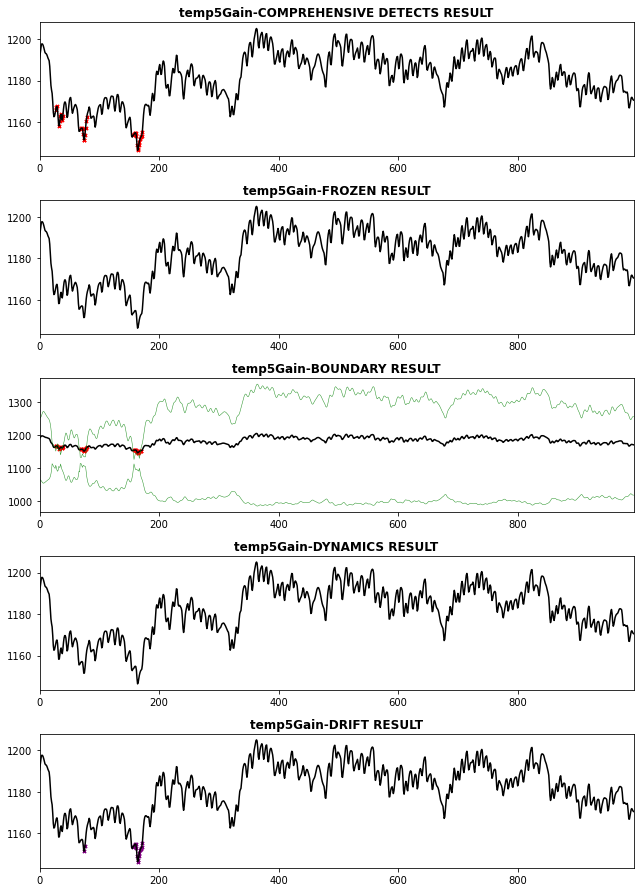

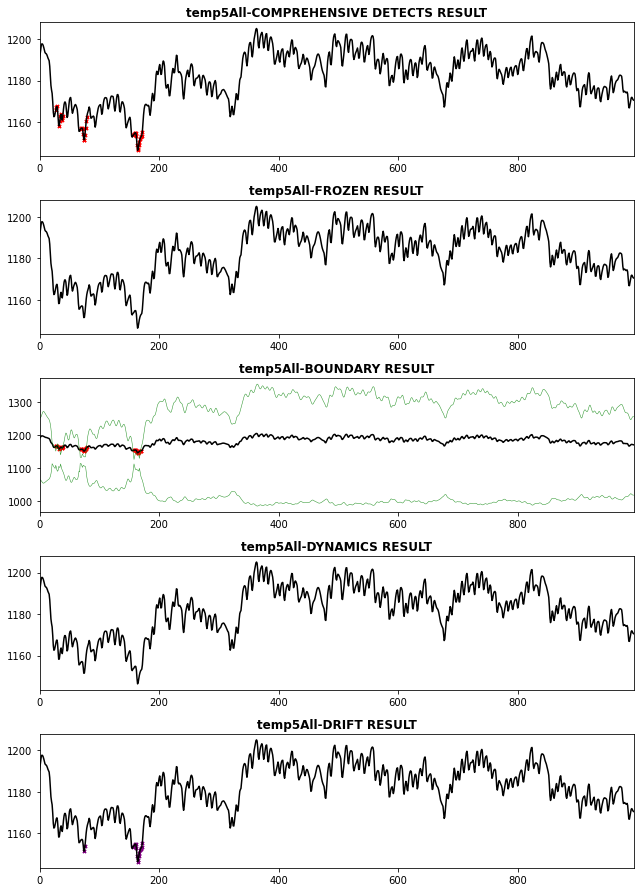

In [11]:
import matplotlib.pyplot as plt

for tag in test_tag_list:
    # 테스트 데이터 리스트
    test_data_list = list(test_data[tag].values[tracking_size:].flatten())

    # 검출 결과를 담은 리스트
    detect_chk = [t if d else None for t, d in zip(test_data_list, detecteds[tag])]
    frz_chks = [t if d else None for t, d in zip(test_data_list, frz_res[tag])]
    bounds_chks = [t if d else None for t, d in zip(test_data_list, bounds_res[tag])]
    dyn_chks = [t if d else None for t, d in zip(test_data_list, dyn_res[tag])]
    drft_chks = [t if d else None for t, d in zip(test_data_list, drft_res[tag])]

    # 검출 결과 리스트를 하나로 묶음
    chks = [detect_chk, frz_chks, bounds_chks, dyn_chks, drft_chks]

    # 그래프에 표시될 각 검출 결과의 이름
    keys = ['Comprehensive Detects', 'frozen', 'boundary', 'dynamics', 'drift']

    # 각 검출 결과의 색상
    colors = ['red', 'blue', 'red', 'orange', 'purple']

    # 그래프 생성
    fig, axs = plt.subplots(len(chks), 1, figsize=(9, 2.5 * len(chks)))
    for i, ax in enumerate(axs):
        # 현재 그래프에서 표시할 검출 결과 리스트
        chk = chks[i]
        
        # 검출 결과 이름
        key = keys[i].upper()
        
        # 검출 결과에 대한 색상
        color = colors[i]
        
        # 검출 결과 리스트를 검은색 실선으로 그리기
        ax.plot(test_data_list[:len(chk)], c='k')
        
        # 검출 결과 리스트를 산점도로 그리기
        ax.scatter(x=range(len(chk)), y=chk, s=10.5, c=color, marker='x')
        
        # x축 범위 설정
        ax.set_xlim(0, len(chk)-1)
        
        # 그래프 제목 설정 (검출 결과 이름, bold체로)
        ax.set_title(f"{tag}-{key} RESULT", fontweight='bold')

        # Boundary 출력
        if i == 2:
            ax.plot(high_boundary[tag], c='g', alpha=0.82 , linewidth=0.52)
            ax.plot(low_boundary[tag], c='g', alpha=0.82, linewidth=0.52)

    # 그래프 간격 설정 및 출력
    plt.tight_layout()
    plt.show();